In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm, vhmm
import joblib
import seaborn as sns
import networkx as nx
import pprint as pprint

# Import data

Chargement des corrdonnées du museau 

In [ ]:
X = pd.pandas.read_csv("E:/UQAM/Recherche/Code/data/Jennie_boxes_cow_head_snout.csv",  names=None)
# ['cow L', 'cow T', 'cow W', 'cow H', 'Head L', 'Head T', 'Head W', 'Head H', 'snout L', 'snout R', 'snout W', 'snout H']
pprint.pp(X)

# X = np.concatenate([X_head, X_snout, X_cow], axis=1)
df = pd.DataFrame(X)

print(df.shape, X.shape)

(47852, 13) (47852, 13)


# Train model

In [32]:
em_scores = list()
vi_scores = list()
em_models = list()
vi_models = list()

for n_components in range(2, 10):
    for idx in range(10):
        for n_iter in range(40, 100):
            em_model = hmm.GaussianHMM(n_components=n_components, random_state=idx,covariance_type = "full", n_iter=52)
            em_model.fit(df)
            em_models.append(em_model)
            em_scores.append(em_model.score(df))
        # variational inference
        vi_model = vhmm.VariationalGaussianHMM(n_components=n_components, random_state=idx, covariance_type='full', n_iter=52)
        vi_model.fit(df)
        vi_models.append(vi_model)
        vi_scores.append(vi_model.score(df))
        # ll = em_model.monitor_.history[-1]
        """ print(f"Training EM({n_components}) Final Log Likelihood={ll} "
              f"Iterations={len(vi_model.monitor_.history)} ") """
        # print(f'Converged: {em_model.monitor_.converged}\t\t'f'Score: {scores[-1]}')

# get the best model
em_model = em_models[np.argmax(em_scores)]
vi_model = vi_models[np.argmax(vi_scores)]
# print(f'The best model had a score of {max(scores)} and 'f'{em_model.n_components} components')


em_Z = em_model.predict(X)
vi_Z = vi_model.predict(X)


Model is not converging.  Current: -2387147.5175845046 is not greater than -2387147.5175843104. Delta is -1.9418075680732727e-07
Model is not converging.  Current: -2387121.665461664 is not greater than -2387121.665459208. Delta is -2.455897629261017e-06
Model is not converging.  Current: -2374643.721779837 is not greater than -2374643.721776997. Delta is -2.839602530002594e-06
Model is not converging.  Current: -2378609.4273258196 is not greater than -2378609.4273239365. Delta is -1.8831342458724976e-06


KeyboardInterrupt: 

In [ ]:

joblib.dump(em_model, 'models/EM/hmm_jennie_model.pkl')
joblib.dump(vi_model, 'models/Vi/hmm_jennie_model.pkl')

print(em_model.means_)
print(len(em_Z)/30)
print(vi_model.means_)
#print(model.covars_)

[[22916.35690742   526.9246053    356.26512432   347.93192396
    406.12679352   649.02538969   367.40810504   225.82712814
    229.712665     794.30618052   543.67305492    46.58655967
     52.08502517]
 [12808.79784068   603.34306572   245.6146349    331.54957045
    516.06811556   722.82946123   337.41197111   212.03391833
    250.79026971   866.48311573   526.73833745    51.07794329
     51.59555664]
 [30660.84150696   436.0647858    249.87442385   415.42674629
    519.29210251   449.97263666   383.08330386   271.97041225
    240.83607529   529.11710765   567.62064773    55.48706393
     45.67634627]
 [25326.42027477   565.22543595   282.21498396   332.79583792
    476.24857032   676.90283567   381.7203672    219.56159966
    237.10362815   807.58577101   566.44091778    47.26726859
     48.57624939]]
1595.0666666666666
[[24809.226444     523.23697241   369.4142791    352.27445038
    393.03781935   648.85002213   382.89637305   226.39589257
    226.6665611    797.52116619   556.68

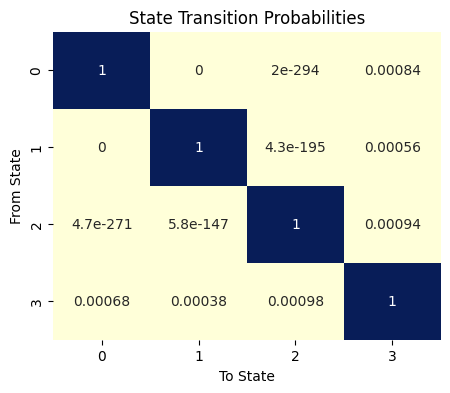

In [ ]:
transition_matrix = em_model.transmat_
plt.figure(figsize=(5, 4))
sns.heatmap(transition_matrix, annot=True, cmap="YlGnBu", cbar=False)
plt.title('State Transition Probabilities')
plt.xlabel('To State')
plt.ylabel('From State')
plt.show()

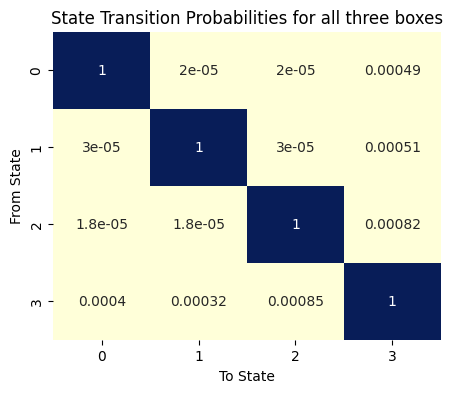

In [ ]:
transition_matrix = vi_model.transmat_
plt.figure(figsize=(5, 4))
sns.heatmap(transition_matrix, annot=True, cmap="YlGnBu", cbar=False)
plt.title('State Transition Probabilities for all three boxes')
plt.xlabel('To State')
plt.ylabel('From State')
plt.show()

In [ ]:

states = pd.DataFrame(em_Z)
states.to_csv("../INF889E Project/Trained data/EM/jennie_states.csv")

states = pd.DataFrame(vi_Z)
states.to_csv("../INF889E Project/Trained data/VI/jennie_states.csv")


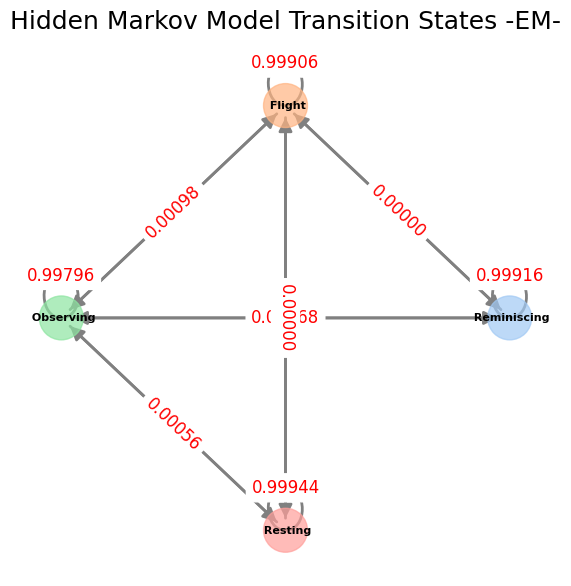

In [ ]:
# Create a directed graph using NetworkX
G = nx.DiGraph()
transition_matrix = em_model.transmat_
num_states = transition_matrix.shape[0]
dic_state = {
    1 : 'Resting',
    3 : 'Observing',
    2 : 'Flight',
    0 : 'Reminiscing'
}
for i in range(num_states):
    for j in range(num_states):
        prob = transition_matrix[i, j]
        if prob > 0:  # Only add edges for non-zero probabilities
            G.add_edge(f' {dic_state[i]}', f' {dic_state[j]}', weight=prob)


# Use a color palette from seaborn for visual appeal
colors = sns.color_palette("pastel", num_states)

# Visualize the graph with enhanced aesthetics
pos = nx.circular_layout(G)
edge_labels = {(n1, n2): f"{d['weight']:.5f}" for n1, n2, d in G.edges(data=True)}

plt.figure(figsize=(7, 7))
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=colors, node_shape="o", alpha=0.7)
nx.draw_networkx_edges(G, pos, width=2, edge_color="gray", arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=12)

plt.title('Hidden Markov Model Transition States -EM-', fontsize=18)
plt.axis('off')
plt.show()

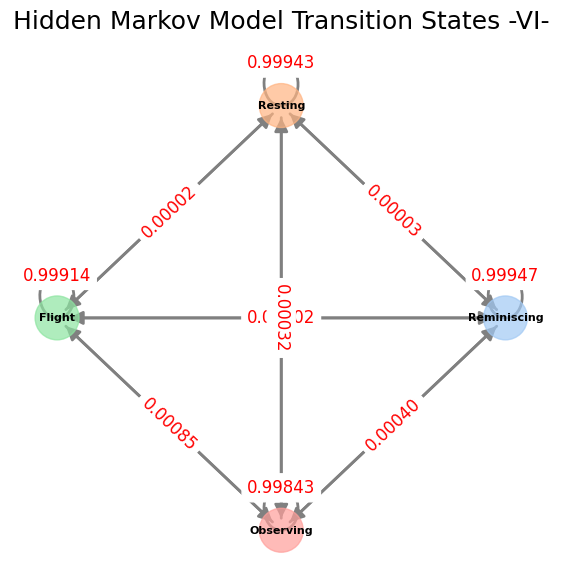

In [ ]:
# Create a directed graph using NetworkX
G = nx.DiGraph()
transition_matrix = vi_model.transmat_
num_states = transition_matrix.shape[0]
for i in range(num_states):
    for j in range(num_states):
        prob = transition_matrix[i, j]
        if prob > 0:  # Only add edges for non-zero probabilities
            G.add_edge(dic_state[i], dic_state[j], weight=prob)

# Use a color palette from seaborn for visual appeal
colors = sns.color_palette("pastel", num_states)

# Visualize the graph with enhanced aesthetics
pos = nx.circular_layout(G)
edge_labels = {(n1, n2): f"{d['weight']:.5f}" for n1, n2, d in G.edges(data=True)}

plt.figure(figsize=(7, 7))
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=colors, node_shape="o", alpha=0.7)
nx.draw_networkx_edges(G, pos, width=2, edge_color="gray", arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=12)

plt.title('Hidden Markov Model Transition States -VI-', fontsize=18)
plt.axis('off')
plt.show()

0        508.2353
1        508.2406
2        508.2437
3        508.2591
4        508.2866
           ...   
47847    266.3852
47848    266.3992
47849    266.4113
47850    266.4301
47851    266.4510
Name: cow H, Length: 47852, dtype: float64


Text(0.5, 0.98, 'Cow Coordinates (Jenny), EM gaussian')

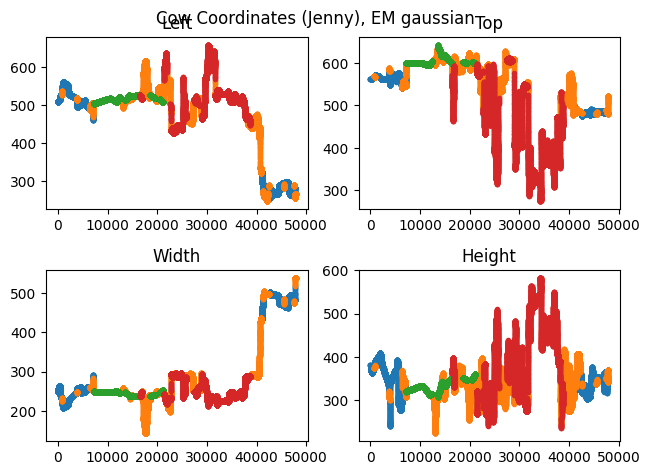

In [ ]:
states_em = pd.unique(em_Z)
print(df['cow H'])
plt.subplot(2,2,1)
for i in states_em:
    x = np.linspace(1,len(df['cow H']),len(df['cow H']))[(em_Z == i)]
    y = df['cow H'][(em_Z == i)]
    plt.plot(x, y, '.')
    plt.title("Left")
plt.subplot(2,2,2)
for i in states_em:
    x = np.linspace(1,len(df['cow L']),len(df['cow L']))[(em_Z == i)]
    y = df['cow L'][(em_Z == i)]
    plt.plot(x, y, '.')
    plt.title("Top")
plt.subplot(2,2,3)
for i in states_em:
    x = np.linspace(1,len(df['cow T']),len(df['cow T']))[(em_Z == i)]
    y = df['cow T'][(em_Z == i)]
    plt.plot(x, y, '.')
    plt.title("Width")
plt.subplot(2,2,4)
for i in states_em:
    x = np.linspace(1,len(df['cow W']),len(df['cow W']))[(em_Z == i)]
    y = df['cow W'][(em_Z == i)]
    plt.plot(x, y, '.')
    plt.title("Height")


plt.tight_layout()
# plt.legend(labels=state_names, loc="lower right", ncol=1)
plt.suptitle('Cow Coordinates (Jenny), EM gaussian')

Text(0.5, 0.98, 'Head Coordinates (Jenny), EM gaussian')

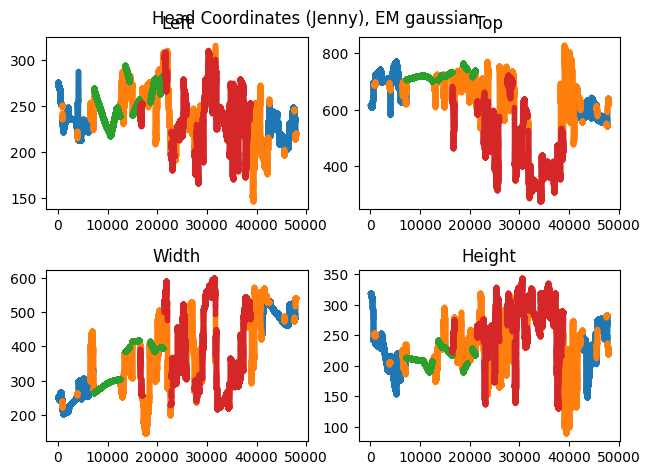

In [ ]:
states_em = pd.unique(em_Z)
plt.subplot(2,2,1)
for i in states_em:
    x = np.linspace(1,len(df['head H']),len(df['head H']))[(em_Z == i)]
    y = df['head H'][(em_Z == i)]
    plt.plot(x, y, '.')
    plt.title("Left")
plt.subplot(2,2,2)
for i in states_em:
    x = np.linspace(1,len(df['head L']),len(df['head L']))[(em_Z == i)]
    y = df['head L'][(em_Z == i)]
    plt.plot(x, y, '.')
    plt.title("Top")
plt.subplot(2,2,3)
for i in states_em:
    x = np.linspace(1,len(df['head T']),len(df['head T']))[(em_Z == i)]
    y = df['head T'][(em_Z == i)]
    plt.plot(x, y, '.')
    plt.title("Width")
plt.subplot(2,2,4)
for i in states_em:
    x = np.linspace(1,len(df['head W']),len(df['head W']))[(em_Z == i)]
    y = df['head W'][(em_Z == i)]
    plt.plot(x, y, '.')
    plt.title("Height")


plt.tight_layout()
# plt.legend(labels=state_names, loc="lower right", ncol=1)
plt.suptitle('Head Coordinates (Jenny), EM gaussian')

KeyError: 'snout T'

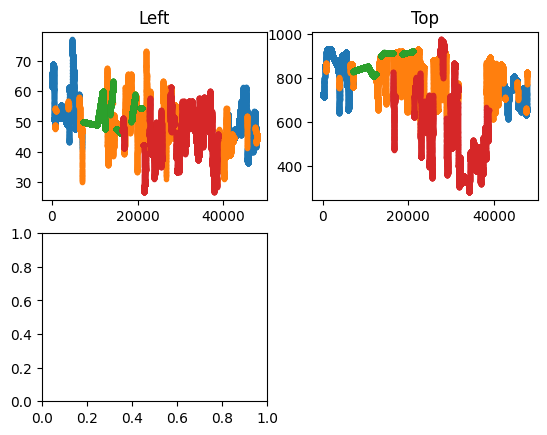

In [ ]:
states_em = pd.unique(em_Z)
plt.subplot(2,2,1)
for i in states_em:
    x = np.linspace(1,len(df['snout H']),len(df['snout H']))[(em_Z == i)]
    y = df['snout H'][(em_Z == i)]
    plt.plot(x, y, '.')
    plt.title("Left")
plt.subplot(2,2,2)
for i in states_em:
    x = np.linspace(1,len(df['snout L']),len(df['snout L']))[(em_Z == i)]
    y = df['snout L'][(em_Z == i)]
    plt.plot(x, y, '.')
    plt.title("Top")
plt.subplot(2,2,3)
for i in states_em:
    x = np.linspace(1,len(df['snout R']),len(df['snout R']))[(em_Z == i)]
    y = df['snout R'][(em_Z == i)]
    plt.plot(x, y, '.')
    plt.title("Width")
plt.subplot(2,2,4)
for i in states_em:
    x = np.linspace(1,len(df['snout W']),len(df['snout W']))[(em_Z == i)]
    y = df['snout W'][(em_Z == i)]
    plt.plot(x, y, '.')
    plt.title("Height")


plt.tight_layout()
# plt.legend(labels=state_names, loc="lower right", ncol=1)
plt.suptitle('Snout Coordinates (Jenny), EM gaussian')

In [ ]:
remodel.monitor_
remodel.monitor_.converged
